In [1]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools
using Plots
using Random

import ProgressMeter

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.


In [2]:
function hgf(n, iters, data, real_k, real_w, z_variance, y_variance)
    model = Model()
    
    xt_min_mean = datavar(model, :xt_min_mean, PointMass{Float64})
    xt_min_var  = datavar(model, :xt_min_var, PointMass{Float64})
    xt_min      = randomvar(model, :xt_min)
    
    xt_min_prior = make_node(model, NormalMeanVariance, xt_min, xt_min_mean, xt_min_var)
    
    zt_min_mean = datavar(model, :zt_min_mean, PointMass{Float64})
    zt_min_var  = datavar(model, :zt_min_var, PointMass{Float64})
    zt_min      = randomvar(model, :zt_min)
    
    zt_min_prior = make_node(model, NormalMeanVariance, zt_min, zt_min_mean, zt_min_var)
    
    zvar   = constvar(model, :zvar, z_variance)
    zt     = randomvar(model, :zt)
    
    z_transition = make_node(model, NormalMeanVariance, zt, zt_min, zvar, factorisation = ((1,),(2,),(3,)))
    
    xt = randomvar(model, :xt)
    kt = constvar(model, :kt, real_k)
    ωt = constvar(model, :wt, real_w)
    
    gcv = make_node(model, GCV, xt, xt_min, zt, kt, ωt, factorisation = ((1, 2), (3,), (4,), (5, )))
    
    y_var = constvar(model, :y_var, y_variance)
    y     = datavar(model, :y, PointMass{Float64})
    
    obs = make_node(model, NormalMeanVariance, y, xt, y_var)
    
    activate!(model)
    
    ms_scheduler = PendingScheduler()
    fe_scheduler = PendingScheduler() # 
    fe = Vector{Float64}()    
    fe_sub = subscribe!(score(BetheFreeEnergy(), model, fe_scheduler), (d) -> push!(fe, d))
    
    mz = Vector{NormalMeanVariance}()
    tt = Vector{MvNormalMeanCovariance}()
    mx = Vector{NormalMeanVariance}()
    

    s_mz = subscribe!(getmarginal(zt) |> schedule_on(ms_scheduler), (t) -> push!(mz, getdata(t)))
    s_mx = subscribe!(getmarginal(xt) |> schedule_on(ms_scheduler), (t) -> push!(mx, getdata(t)))
    
    # Initial prior messages
    current_zt = NormalMeanVariance(0.0, 100.0)
    current_xt = NormalMeanVariance(0.0, 100.0)

    # Prior marginals
    setmarginal!(gcv, :y_x, MvNormalMeanCovariance([ 0.0, 0.0 ], [ 5.0, 5.0 ]))
    setmarginal!(gcv, :z, NormalMeanVariance(0.0, 5.0))
    
    for i in 1:n
        
        for _ in 1:iters
            update!(y, data[i])
            update!(zt_min_mean, mean(current_zt))
            update!(zt_min_var, var(current_zt))
            update!(xt_min_mean, mean(current_xt))
            update!(xt_min_var, var(current_xt))
            release!(fe_scheduler)
        end
        
        release!(ms_scheduler)
        
        current_zt = mz[end]
        current_xt = mx[end]
    end
    
    unsubscribe!(s_mz)
    unsubscribe!(s_mx)
    unsubscribe!(fe_sub)
    
    return mz, mx, fe
end

hgf (generic function with 1 method)

In [3]:
n = 1000
iters = 10

Random.seed!(223)

real_k = 1.0
real_w = 0.0

z_prev     = 0.0
z_variance = 0.1

z = Vector{Float64}(undef, n)
for i in 1:n
    z[i] = rand(Normal(z_prev, sqrt(z_variance)))
    z_prev = z[i]
end

# z = map(d -> 2.0 * sin(0.005 * d), 1:n)

v = map(d -> exp(real_k * d + real_w), z)

x_prev = 0.0

x = Vector{Float64}(undef, n)

for i in 1:n
    x[i] = rand(Normal(x_prev, sqrt(v[i])))
    x_prev = x[i]
end

y = Vector{Float64}(undef, n)
y_variance = 1.0

for i in 1:n
    y[i] = rand(Normal(x[i], sqrt(y_variance)))
end

In [4]:
@time mz, mx, fe = hgf(n, iters, y, real_k, real_w, z_variance, y_variance); # Initial compilation

 18.876644 seconds (62.15 M allocations: 3.063 GiB, 6.35% gc time)


In [5]:
@time mz, mx, fe = hgf(n, iters, y, real_k, real_w, z_variance, y_variance); # Subsequent runs

  0.354800 seconds (4.01 M allocations: 191.806 MiB, 10.75% gc time)


In [6]:
@btime hgf($n, $iters, $y, $real_k, $real_w, $z_variance, $y_variance); # Benchmark

  321.454 ms (4008917 allocations: 191.81 MiB)


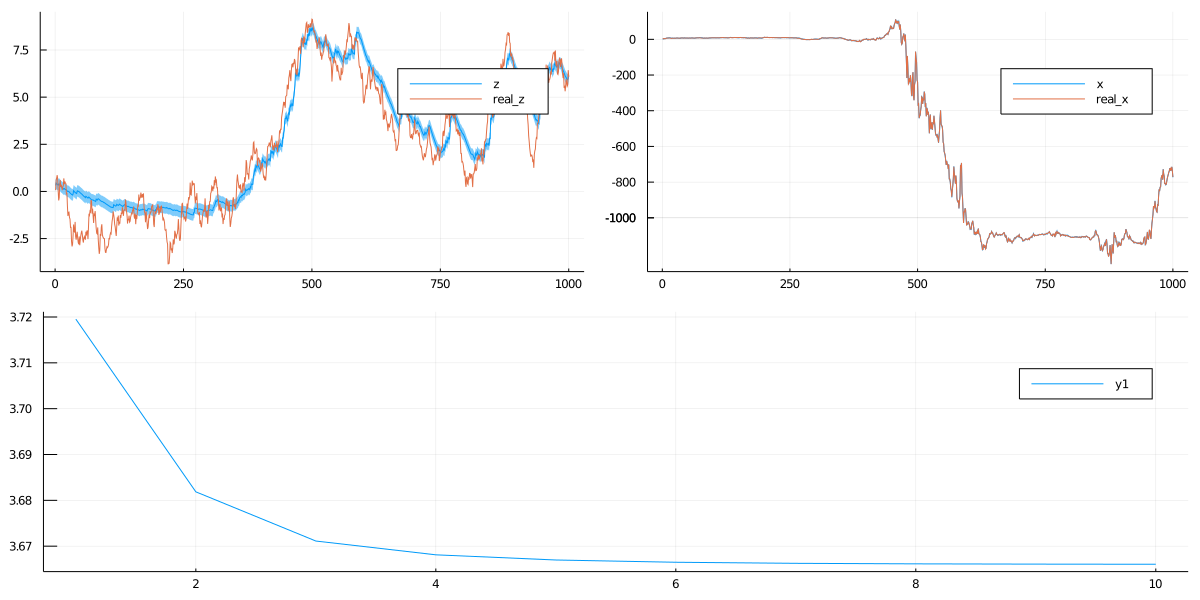

In [7]:
p1 = plot(mean.(mz), ribbon = std.(mz), label = :z)
p1 = plot!(p1, z, label = :real_z)

p2 = plot(mean.(mx), ribbon = std.(mx), label = :x)
p2 = plot!(p2, x, label = :real_x)

p3 = plot(sum(reshape(fe, (iters, n)), dims = 2) / n)

plot(p1, p2, p3, layout = @layout([ a b; c ]), size = (1200, 600))